# 使用Gluon对CIFAR10进行分类

In [1]:
import mxnet as mx
import numpy as np
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 整理数据

In [2]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [3]:
data_dir = 'data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [4]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4465]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = nd.transpose(im, (2,0,1))
    im = nd.expand_dims(im, axis=0)
    im = nd.pad(im, pad_width=(0,0,0,0,2,2,2,2), constant_value=0, mode='constant')[0]
    im = nd.transpose(im, (1,2,0))
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=True, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 128
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(128, 3, 32, 32)


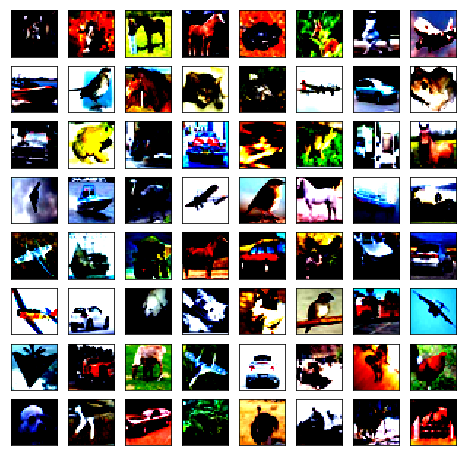

In [5]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## ResNet v2

In [6]:
def BN_ReLU_Conv(num_filter, kernel_size, strides=1, padding=0, erase_relu=False, 
                 erase_conv=False, use_bias=False):
    '''
    num_filter : Int
        The output channel of this unit
    kernel_size : int
        Kernel size of the Conv kernel
    strides : int or tuple
        Conv strides
    padding : int or tuple
        Conv padding
    erase_relu : Boolean
        whether erase relu
    use_bias : Boolean
        Whether use bias
    '''
    unit = gluon.nn.HybridSequential()
    with unit.name_scope():
        unit.add(gluon.nn.BatchNorm(axis=1, epsilon=2e-5))
        if not erase_relu:
            unit.add(gluon.nn.Activation('relu'))
        if not erase_conv:
            unit.add(gluon.nn.Conv2D(num_filter, kernel_size=kernel_size, strides=strides, 
                                 padding=padding, use_bias=use_bias))
    return unit

def BN_ReLU(erase_relu=False):
    '''
    erase_relu : Boolean
        whether erase relu
    '''
    unit = gluon.nn.HybridSequential()
    with unit.name_scope():
        unit.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            unit.add(gluon.nn.Activation('relu'))
    return unit

class Residual_Unit(gluon.nn.HybridBlock):
    def __init__(self, num_filter, strides, dim_match=True, bottle_neck=False, **kwargs):
        super().__init__(**kwargs)
        self.dim_match = dim_match
        self.bottle_neck = bottle_neck
        residual = self.residual = gluon.nn.HybridSequential()
        with self.name_scope():
            if bottle_neck:
                residual.add(BN_ReLU_Conv(int(num_filter * 0.25), kernel_size=1, erase_relu=True))  
                residual.add(BN_ReLU_Conv(int(num_filter * 0.25), kernel_size=3, strides=strides, padding=1))
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=1))
            else:
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=3, strides=strides, padding=1, erase_relu=True))
                residual.add(BN_ReLU_Conv(num_filter, kernel_size=3, strides=1, padding=1))
            # add this final BNB layer
            residual.add(gluon.nn.BatchNorm(axis=1, epsilon=2e-5))
        if not dim_match:
            self.conv1 = gluon.nn.Conv2D(num_filter, kernel_size=1, strides=strides, use_bias=False)
            self.bn_relu = BN_ReLU()
    
    def hybrid_forward(self, F, X):
        if self.dim_match:
            shortcut = X
        else:
            shortcut = self.conv1(self.bn_relu(X))
        output = self.residual(X)
        return output + shortcut

class ResNet(gluon.nn.HybridBlock):
    def __init__(self, unit_list, filter_list, num_classes, data_type, bottle_neck=False, debug=False, **kwargs):
        '''
        unit_list : list
            num of unit per stage
        filter_list : list
            channnel size of each stage 
        num_classes : int
            num of classes
        bottle_neck : bool
            the bottle_neck archeitecture
        debug : bool
            print the shape of each stage 
        '''
        super().__init__(**kwargs)
        num_stage = len(unit_list)
        self.debug = debug
    
        resnet = self.resnet = gluon.nn.HybridSequential()
        with self.name_scope():
            # first layer 
            blk1 = gluon.nn.HybridSequential()
            blk1.add(gluon.nn.BatchNorm(axis=1))
            if data_type == 'cifar10':
                blk1.add(gluon.nn.Conv2D(filter_list[0], kernel_size=3, padding=1, use_bias=False))
            elif data_type == 'imagenet':
                blk1.add(
                    gluon.nn.Conv2D(filter_list[0], kernel_size=7, strides=2, padding=3, use_bias=False),
                    gluon.nn.BatchNorm(axis=1),
                    gluon.nn.Activation('relu'),
                    gluon.nn.MaxPool2D(pool_size=3, strides=2, padding=1)
                )
            else:
                raise ValueError('do not support {} yet.'.format(data_type))
            resnet.add(blk1)
            
            # residual layer 
            for i in range(num_stage):
                blk2 = gluon.nn.HybridSequential()
                blk2.add(Residual_Unit(filter_list[i+1], 1 if i==0 else 2, False, 
                                      bottle_neck=bottle_neck))
                for j in range(unit_list[i] - 1):
                    blk2.add(Residual_Unit(filter_list[i+1], 1, True, bottle_neck=bottle_neck))
                resnet.add(blk2)
            
            # regularizaiton layer 
            blk3 = gluon.nn.HybridSequential()
            blk3.add(
                gluon.nn.BatchNorm(axis=1),
                gluon.nn.Activation('relu')
            )
            resnet.add(blk3)
            
            # classification layer 
            blk4 = gluon.nn.HybridSequential()
            blk4.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
            resnet.add(blk4)

    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.resnet):
            out = blk(out)
            # if self.debug:
                # print('blk {} : {}'.format(i+1, out.shape))
        return out

In [7]:
depth = 200

if (depth-2)%9 == 0 and depth >= 164:
    per_unit = [int((depth-2)/9)]
    filter_list = [16, 64, 128, 256]
    bottle_neck = True
elif (depth-2)%6 == 0 and depth < 164:
    per_unit = [int((depth-2)/6)]
    filter_list = [16, 16, 32, 64]
    bottle_neck = False
else:
    raise ValueError("depth {} error.".format(depth))
unit_list = per_unit * 3

symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.initialize()
sample = nd.random.uniform(shape=(128, 3, 32, 32))
y = symbol(sample)

In [8]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if 0 <= epoch <= 1:
            trainer.set_learning_rate(0.01)
        if epoch == 2:
            trainer.set_learning_rate(0.1)
        if epoch == 150:
            trainer.set_learning_rate(0.01)
        if epoch == 225:
            trainer.set_learning_rate(0.001)
        if epoch == 260:
            trainer.set_learning_rate(0.0001)
        if epoch == 280:
            trainer.set_learning_rate(0.00005)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('sparsenet-cifar10-%d.params' % (epoch))
        else:
            print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss,train_acc, time() - start))

In [ ]:
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in'
                                                               , magnitude=2.))
symbol.hybridize()
train(symbol, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.81062, Test Loss : 1.74531, Train Acc : 0.31613, Test Acc : 0.36260, Time Consume 211.886395 s.
[Epoch 1] Train Moving Loss : 1.65272, Test Loss : 1.54693, Train Acc : 0.38644, Test Acc : 0.43300, Time Consume 195.792941 s.
[Epoch 2] Train Moving Loss : 1.55992, Test Loss : 1.47081, Train Acc : 0.40418, Test Acc : 0.46280, Time Consume 195.053583 s.
[Epoch 3] Train Moving Loss : 1.31944, Test Loss : 1.22865, Train Acc : 0.51400, Test Acc : 0.56240, Time Consume 195.133951 s.
[Epoch 4] Train Moving Loss : 1.15993, Test Loss : 1.50340, Train Acc : 0.49791, Test Acc : 0.51860, Time Consume 195.641054 s.
[Epoch 5] Train Moving Loss : 1.03682, Test Loss : 0.87199, Train Acc : 0.62689, Test Acc : 0.69660, Time Consume 195.010295 s.
[Epoch 6] Train Moving Loss : 0.97643, Test Loss : 0.96979, Train Acc : 0.61738, Test Acc : 0.68340, Time Consume 195.068824 s.
[Epoch 7] Train Moving Loss : 0.86951, Test Loss : 0.75424, Train Acc : 0.66213, Test Acc : 0.73740, Tim

[Epoch 64] Train Moving Loss : 0.50379, Test Loss : 0.31506, Train Acc : 0.82478, Test Acc : 0.88620, Time Consume 191.146490 s.
[Epoch 65] Train Moving Loss : 0.51583, Test Loss : 0.34541, Train Acc : 0.81233, Test Acc : 0.88460, Time Consume 194.572241 s.
[Epoch 66] Train Moving Loss : 0.53546, Test Loss : 0.37296, Train Acc : 0.80860, Test Acc : 0.87600, Time Consume 194.473611 s.
[Epoch 67] Train Moving Loss : 0.48924, Test Loss : 0.41085, Train Acc : 0.80302, Test Acc : 0.86140, Time Consume 194.067474 s.
[Epoch 68] Train Moving Loss : 0.50030, Test Loss : 0.36149, Train Acc : 0.81420, Test Acc : 0.87540, Time Consume 193.850507 s.
[Epoch 69] Train Moving Loss : 0.48330, Test Loss : 0.33475, Train Acc : 0.81322, Test Acc : 0.88460, Time Consume 179.945005 s.
[Epoch 70] Train Moving Loss : 0.50660, Test Loss : 0.35698, Train Acc : 0.81376, Test Acc : 0.88260, Time Consume 173.119594 s.
[Epoch 71] Train Moving Loss : 0.48544, Test Loss : 0.31489, Train Acc : 0.82067, Test Acc : 0.89

[Epoch 128] Train Moving Loss : 0.46792, Test Loss : 0.30882, Train Acc : 0.83738, Test Acc : 0.89600, Time Consume 172.703418 s.
[Epoch 129] Train Moving Loss : 0.40352, Test Loss : 0.28025, Train Acc : 0.84296, Test Acc : 0.91000, Time Consume 173.263638 s.
[Epoch 130] Train Moving Loss : 0.47305, Test Loss : 0.28146, Train Acc : 0.84378, Test Acc : 0.90420, Time Consume 174.303123 s.
[Epoch 131] Train Moving Loss : 0.48082, Test Loss : 0.25980, Train Acc : 0.84751, Test Acc : 0.90920, Time Consume 174.025825 s.
[Epoch 132] Train Moving Loss : 0.45310, Test Loss : 0.33159, Train Acc : 0.82678, Test Acc : 0.88820, Time Consume 173.867178 s.
[Epoch 133] Train Moving Loss : 0.47064, Test Loss : 0.38918, Train Acc : 0.81236, Test Acc : 0.87640, Time Consume 172.918444 s.
[Epoch 134] Train Moving Loss : 0.44509, Test Loss : 0.29741, Train Acc : 0.83469, Test Acc : 0.90600, Time Consume 174.061541 s.
[Epoch 135] Train Moving Loss : 0.41305, Test Loss : 0.28413, Train Acc : 0.85062, Test Ac

[Epoch 192] Train Moving Loss : 0.22080, Test Loss : 0.14970, Train Acc : 0.92978, Test Acc : 0.95660, Time Consume 174.114125 s.
[Epoch 193] Train Moving Loss : 0.21460, Test Loss : 0.16127, Train Acc : 0.93380, Test Acc : 0.95060, Time Consume 173.795047 s.
[Epoch 194] Train Moving Loss : 0.21572, Test Loss : 0.16489, Train Acc : 0.92991, Test Acc : 0.95160, Time Consume 172.879726 s.
[Epoch 195] Train Moving Loss : 0.22254, Test Loss : 0.16813, Train Acc : 0.93300, Test Acc : 0.95320, Time Consume 172.902727 s.
[Epoch 196] Train Moving Loss : 0.21723, Test Loss : 0.16489, Train Acc : 0.93107, Test Acc : 0.95100, Time Consume 173.870288 s.
[Epoch 197] Train Moving Loss : 0.20425, Test Loss : 0.15782, Train Acc : 0.93071, Test Acc : 0.95220, Time Consume 172.801936 s.
[Epoch 198] Train Moving Loss : 0.21394, Test Loss : 0.16982, Train Acc : 0.93284, Test Acc : 0.95080, Time Consume 172.869689 s.
[Epoch 199] Train Moving Loss : 0.20275, Test Loss : 0.16926, Train Acc : 0.93096, Test Ac

[Epoch 256] Train Moving Loss : 0.16580, Test Loss : 0.15667, Train Acc : 0.94618, Test Acc : 0.95720, Time Consume 173.606983 s.
[Epoch 257] Train Moving Loss : 0.15565, Test Loss : 0.15772, Train Acc : 0.94789, Test Acc : 0.95800, Time Consume 173.327106 s.
[Epoch 258] Train Moving Loss : 0.15444, Test Loss : 0.15794, Train Acc : 0.94578, Test Acc : 0.95780, Time Consume 174.333391 s.
[Epoch 259] Train Moving Loss : 0.16030, Test Loss : 0.15438, Train Acc : 0.94638, Test Acc : 0.95660, Time Consume 172.687499 s.
[Epoch 260] Train Moving Loss : 0.17197, Test Loss : 0.15364, Train Acc : 0.94733, Test Acc : 0.95740, Time Consume 172.721900 s.
[Epoch 261] Train Moving Loss : 0.16983, Test Loss : 0.15433, Train Acc : 0.94687, Test Acc : 0.95740, Time Consume 173.458282 s.
[Epoch 262] Train Moving Loss : 0.17045, Test Loss : 0.15466, Train Acc : 0.94527, Test Acc : 0.95780, Time Consume 174.232348 s.
[Epoch 263] Train Moving Loss : 0.18909, Test Loss : 0.15281, Train Acc : 0.94667, Test Ac

In [9]:
import pandas as pd

ctx = mx.gpu()
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
symbol = ResNet(unit_list=unit_list, filter_list=filter_list, num_classes=10, 
                data_type='cifar10', bottle_neck=bottle_neck, debug=True)
symbol.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in'
                                                               , magnitude=2.))
symbol.hybridize()
train(symbol, train_data, None, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.83518, Train Acc : 0.32978, Time Consume 786.591524 s.
[Epoch 1] Train Moving Loss : 1.69481, Train Acc : 0.37484, Time Consume 188.311099 s.
[Epoch 2] Train Moving Loss : 1.62042, Train Acc : 0.38784, Time Consume 184.659036 s.
[Epoch 3] Train Moving Loss : 1.27730, Train Acc : 0.51504, Time Consume 184.335471 s.
[Epoch 4] Train Moving Loss : 1.14216, Train Acc : 0.57256, Time Consume 184.446409 s.
[Epoch 5] Train Moving Loss : 1.10257, Train Acc : 0.57804, Time Consume 184.396968 s.
[Epoch 6] Train Moving Loss : 1.04212, Train Acc : 0.59642, Time Consume 183.809273 s.
[Epoch 7] Train Moving Loss : 0.91207, Train Acc : 0.63493, Time Consume 183.727622 s.
[Epoch 8] Train Moving Loss : 0.88616, Train Acc : 0.66864, Time Consume 183.591036 s.
[Epoch 9] Train Moving Loss : 0.83089, Train Acc : 0.69538, Time Consume 183.880168 s.
[Epoch 10] Train Moving Loss : 0.82108, Train Acc : 0.70031, Time Consume 183.921718 s.
[Epoch 11] Train Moving Loss : 0.79076, Tr

[Epoch 94] Train Moving Loss : 0.49263, Train Acc : 0.80744, Time Consume 168.605984 s.
[Epoch 95] Train Moving Loss : 0.50423, Train Acc : 0.80716, Time Consume 168.287411 s.
[Epoch 96] Train Moving Loss : 0.50631, Train Acc : 0.83158, Time Consume 168.520666 s.
[Epoch 97] Train Moving Loss : 0.52461, Train Acc : 0.83153, Time Consume 168.563726 s.
[Epoch 98] Train Moving Loss : 0.47777, Train Acc : 0.83978, Time Consume 168.240903 s.
[Epoch 99] Train Moving Loss : 0.47632, Train Acc : 0.82776, Time Consume 178.248562 s.
[Epoch 100] Train Moving Loss : 0.47802, Train Acc : 0.83469, Time Consume 186.120703 s.
[Epoch 101] Train Moving Loss : 0.48843, Train Acc : 0.83669, Time Consume 186.179642 s.
[Epoch 102] Train Moving Loss : 0.45202, Train Acc : 0.83076, Time Consume 186.324116 s.
[Epoch 103] Train Moving Loss : 0.46058, Train Acc : 0.83400, Time Consume 186.177081 s.
[Epoch 104] Train Moving Loss : 0.48342, Train Acc : 0.83611, Time Consume 186.682604 s.
[Epoch 105] Train Moving Lo

[Epoch 187] Train Moving Loss : 0.21030, Train Acc : 0.93167, Time Consume 187.370462 s.
[Epoch 188] Train Moving Loss : 0.20181, Train Acc : 0.93271, Time Consume 187.538876 s.
[Epoch 189] Train Moving Loss : 0.22835, Train Acc : 0.93156, Time Consume 187.256469 s.
[Epoch 190] Train Moving Loss : 0.19837, Train Acc : 0.93156, Time Consume 187.195507 s.
[Epoch 191] Train Moving Loss : 0.20799, Train Acc : 0.93011, Time Consume 187.397869 s.
[Epoch 192] Train Moving Loss : 0.20679, Train Acc : 0.93062, Time Consume 187.847489 s.
[Epoch 193] Train Moving Loss : 0.20913, Train Acc : 0.93096, Time Consume 187.519192 s.
[Epoch 194] Train Moving Loss : 0.25465, Train Acc : 0.93313, Time Consume 187.523074 s.
[Epoch 195] Train Moving Loss : 0.21111, Train Acc : 0.93076, Time Consume 187.315891 s.
[Epoch 196] Train Moving Loss : 0.21614, Train Acc : 0.93287, Time Consume 187.566978 s.
[Epoch 197] Train Moving Loss : 0.20116, Train Acc : 0.93327, Time Consume 187.467877 s.
[Epoch 198] Train Mov

[Epoch 280] Train Moving Loss : 0.13640, Train Acc : 0.94702, Time Consume 167.751167 s.
[Epoch 281] Train Moving Loss : 0.15802, Train Acc : 0.94553, Time Consume 166.776306 s.
[Epoch 282] Train Moving Loss : 0.14516, Train Acc : 0.94709, Time Consume 167.428028 s.
[Epoch 283] Train Moving Loss : 0.15892, Train Acc : 0.94956, Time Consume 167.033041 s.
[Epoch 284] Train Moving Loss : 0.14591, Train Acc : 0.94771, Time Consume 167.690282 s.
[Epoch 285] Train Moving Loss : 0.15872, Train Acc : 0.95004, Time Consume 166.233499 s.
[Epoch 286] Train Moving Loss : 0.15786, Train Acc : 0.94927, Time Consume 167.671245 s.
[Epoch 287] Train Moving Loss : 0.15972, Train Acc : 0.94764, Time Consume 167.374118 s.
[Epoch 288] Train Moving Loss : 0.15530, Train Acc : 0.94813, Time Consume 166.819871 s.
[Epoch 289] Train Moving Loss : 0.16973, Train Acc : 0.94773, Time Consume 166.961848 s.
[Epoch 290] Train Moving Loss : 0.16287, Train Acc : 0.94638, Time Consume 166.680095 s.
[Epoch 291] Train Mov

In [11]:
preds = []
for data, label in test_data:
     output = symbol(data.as_in_context(ctx))
     preds.extend(output.argmax(axis=1).astype(int).asnumpy())

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key = lambda x:str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)

In [12]:
symbol.save_params('cifar10-resnet200v2-bn-0.95490.params')